In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
from pandas.io.json import json_normalize
from classify_campaigns import classify_campaigns

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [3]:
start_dt = datetime.date.today() - datetime.timedelta(days = 30)
end_dt = datetime.date.today() - datetime.timedelta(days = 1)
print(start_dt)

2021-09-14


impression/cost/revenue from exclusion list users

In [4]:
def calc_metrics(df, i=0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = round(1000*df['installs']/df['impressions'],4)
    df['cpm'] = 1000*df['cost']/df['impressions']
    
    if i != 0:
        df['cost_sov'] = 100*df['cost']/df.groupby(i)['cost'].transform(sum)
        df['total_cost'] = df.groupby(i)['cost'].transform(sum)
        df['revenue_sov'] = 100*df['revenue']/df.groupby(i)['revenue'].transform(sum)
    else:
        df['cost_sov'] = 100*df['cost']/df['cost'].sum()
        df['total_cost'] = df['cost']
        df['revenue_sov'] = 100*df['revenue']/df['revenue'].sum()
        
    df['profit'] = df['revenue']-df['cost']
    df['margin'] = 100*df['profit']/df['revenue']
    return df[['impressions','clicks','ctr','installs','ir','ipm','cpm','revenue','revenue_sov','cost','cost_sov','profit','margin','total_cost']]

format_map = {'impressions':'{:,.0f}'
             ,'bids':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'revenue':'${:,.0f}'
             ,'cost':'${:,.0f}'
             ,'profit':'${:,.0f}'
             ,'bpm':'${:,.2f}'
             ,'cpm':'${:,.2f}'
             ,'win_rate':'{:,.1f}%'
             ,'ctr':'{:,.0f}%'
             ,'margin':'{:,.0f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'revenue_sov':'{:,.1f}%'
             ,'uninstall_rate':'{:,.0f}%'
             ,'cost_sov':'{:,.1f}%'
             ,'imp_sov':'{:,.1f}%'
             ,'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'revenue':'${:,.0f}'
             ,'cost':'${:,.0f}'
             ,'cpm':'${:,.2f}'
             ,'ctr':'{:,.1f}%'
             ,'uninstall_rate':'{:,.1f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'revenue_sov':'{:,.1f}%'
             ,'imp_sov_AdColony':'{:,.1f}%'
             ,'impressions_AdColony':'{:,.0f}'
             ,'clicks_AdColony':'{:,.0f}'
             ,'installs_AdColony':'{:,.0f}'
             ,'revenue_AdColony':'${:,.0f}'
             ,'cost_sov_AdColony':'{:,.0f}%'
             ,'margin_AdColony':'{:,.0f}%'
             ,'profit_AdColony':'${:,.0f}'
             ,'cost_AdColony':'${:,.0f}'
             ,'cpm_AdColony':'${:,.2f}'
             ,'ctr_AdColony':'{:,.1f}%'
             ,'ir_AdColony':'{:,.1f}%'
             ,'ipm_AdColony':'{:,.2f}'
             ,'revenue_sov_AdColony':'{:,.1f}%'
             ,'imp_sov_AppLovin':'{:,.1f}%'
             ,'impressions_AppLovin':'{:,.0f}'
             ,'clicks_AppLovin':'{:,.0f}'
             ,'installs_AppLovin':'{:,.0f}'
             ,'revenue_AppLovin':'${:,.0f}'
             ,'cost_sov_AppLovin':'{:,.0f}%'
             ,'margin_AppLovin':'{:,.0f}%'
             ,'profit_AppLovin':'${:,.0f}'
             ,'cost_AppLovin':'${:,.0f}'
             ,'cpm_AppLovin':'${:,.2f}'
             ,'ctr_AppLovin':'{:,.1f}%'
             ,'ir_AppLovin':'{:,.1f}%'
             ,'ipm_AppLovin':'{:,.2f}'
             ,'revenue_sov_AppLovin':'{:,.1f}%'
             ,'imp_sov_Fyber':'{:,.1f}%'
             ,'impressions_Fyber':'{:,.0f}'
             ,'clicks_Fyber':'{:,.0f}'
             ,'installs_Fyber':'{:,.0f}'
             ,'revenue_Fyber':'${:,.0f}'
             ,'cost_sov_Fyber':'{:,.0f}%'
             ,'margin_Fyber':'{:,.0f}%'
             ,'profit_Fyber':'${:,.0f}'
             ,'cost_Fyber':'${:,.0f}'
             ,'cpm_Fyber':'${:,.2f}'
             ,'ctr_Fyber':'{:,.1f}%'
             ,'ir_Fyber':'{:,.1f}%'
             ,'ipm_Fyber':'{:,.2f}'
             ,'revenue_sov_Fyber':'{:,.1f}%'}

In [5]:
# this is only 5%+ eligiblity 
dt_eligible_campaigns = pd.read_csv('files/dt_eligible_campaigns.csv')
dt_eligible_campaigns = tuple(dt_eligible_campaigns.ssb_campaign_uuid.unique().tolist())

In [6]:
by_creative = bigquery_client.query(f"""
select 
    sp.bundle as sponsored_bnd
    , sp.name as sponsored_app_name
    , c.name as campaign_name
    , r.ssb_buyer_id
    , r.ad_size
    , r.imp_type
    , r.creative_id
    , r.ssb_creative_uuid
    , 4*count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , 4*count(case when event_type = 'click' then 1 else NULL end) as clicks
    , 4*count(case when event_type = 'install' then 1 else NULL end) as installs
    , 4*sum(case when event_type = 'install' then revenue else 0 end) as revenue
    , 4*sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
from stats.rows1 r
join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid
    and c.uuid in {dt_eligible_campaigns}
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and right(r.tid,1) in ('0','1','2','3')
group by 1,2,3,4,5,6,7,8
""").to_dataframe()
by_creative = pd.merge(by_creative, imp_type, left_on = 'imp_type', right_on = 'imp_type_id', how = 'left')
by_creative 

sponsored_bnd  \
0                    com.papaya.solitairecash   
1                            com.gosub60.sol5   
2                            com.sk.babymatch   
3                    com.papaya.solitairecash   
4                    com.papaya.solitairecash   
...                                       ...   
7206  com.murka.braindoku.sudoku.block.puzzle   
7207  com.murka.braindoku.sudoku.block.puzzle   
7208  com.murka.braindoku.sudoku.block.puzzle   
7209  com.murka.braindoku.sudoku.block.puzzle   
7210  com.murka.braindoku.sudoku.block.puzzle   

                                    sponsored_app_name  \
0                                       solitaire cash   
1                                  Solitaire Deluxe® 2   
2                            Affairs 3D: Silly Secrets   
3                                       solitaire cash   
4                                       solitaire cash   
...                                                ...   
7206  Braindoku - Sudoku Block Puzzle & Brain Training   
7207  Braindoku - Sudoku Block Puzzle & Brain Training   
7208  Braindoku - Sudoku Block Puzzle & Brain Training   
7209  Braindoku - Sudoku Block Puzzle & Brain Training   
7210  Braindoku - Sudoku Block Puzzle & Brain Training   

                                     campaign_name  ssb_buyer_id   ad_size  \
0          Papaya Games - Solitaire Cash - US - UA          3549  768x1024   
1           [g|Mdxdeluxe2][p|android][id|12714]_US          2861      None   
2                       Affairs3D-android-us-video          3662  768x1024   
3          Papaya Games - Solitaire Cash - US - UA          3549  768x1024   
4          Papaya Games - Solitaire Cash - US - UA          3549  1024x768   
...                                            ...           ...       ...   
7206      [g|Braindoku][p|android][id|12346]_US_ST          2861   300x250   
7207      [g|Braindoku][p|android][id|12915]_DE_ST          2861  1024x768   
7208      [g|Braindoku][p|android][id|12346]_US_ST          2861    320x50   
7209      [g|Braindoku][p|android][id|12346]_US_ST          2861  1024x768   
7210  [g|Braindoku][p|android][id|12786]_US_banner          2861    320x50   

      imp_type                            creative_id  \
0          2.0  3549_b4f128b52f638c52b7c0918c3183031b   
1          1.0                                   None   
2          2.0  3662_ae72e27f565be8c8579c4169bd00eb84   
3         16.0  3549_90c747fdf9f461e3ecc0301344cc57e8   
4          2.0  3549_5983cebbfa9d8ca575aa85d96c8a7e17   
...        ...                                    ...   
7206       1.0  2861_8f42d7660a3f0b47f91d1024fde24aef   
7207      16.0  2861_9452006d8cfd0e212f527f7d69fcde04   
7208       1.0  2861_9d2eb59b5058753c298beb4fb9307903   
7209       2.0  2861_0396433d74f3b382388a3a3437171996   
7210       1.0  2861_96de1b080743221484bd1d5e6a2c75bf   

                     ssb_creative_uuid  impressions  clicks  installs  \
0     b4f128b52f638c52b7c0918c3183031b        15656    2688       192   
1     52f9d0686b9f081b461e2ae019e96100            0       0         4   
2     ae72e27f565be8c8579c4169bd00eb84        24176    6508      2032   
3     90c747fdf9f461e3ecc0301344cc57e8        74504   17860      1504   
4     5983cebbfa9d8ca575aa85d96c8a7e17         6080    1164       148   
...                                ...          ...     ...       ...   
7206  8f42d7660a3f0b47f91d1024fde24aef           92       0         0   
7207  9452006d8cfd0e212f527f7d69fcde04         1292     180         4   
7208  9d2eb59b5058753c298beb4fb9307903       144676    3772       564   
7209  0396433d74f3b382388a3a3437171996       139660   42924      5232   
7210  96de1b080743221484bd1d5e6a2c75bf      1027208   18656      2888   

      revenue         cost impression type  imp_type_id  
0      572.00   464.322076           video          2.0  
1        4.00     0.000000         display          1.0  
2      592.08   491.436435           video          2.0  
3     4508.00  

<AxesSubplot:>

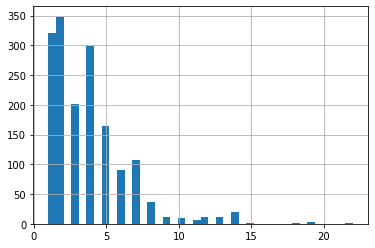

In [7]:
pivot = by_creative.pivot_table(values = ['ssb_creative_uuid'], index = ['campaign_name','impression type','ad_size'], aggfunc = 'count')
pivot['ssb_creative_uuid'].hist(bins = 40)

In [8]:
i = ['campaign_name','impression type','ad_size','creative_id']
pivot = by_creative.pivot_table(values = ['impressions','clicks','installs','revenue','cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, ['campaign_name'])
# format_pivot['revenue_digits_ipm'] = format_pivot.apply(lambda x:str(len(str(int(x.revenue)))) + str(x.ipm), axis = 1).astype(float)

format_pivot.sort_values(['total_cost','impression type','ad_size','cost'], ascending = False, inplace = True)
format_pivot['rank'] = format_pivot.groupby(i[:-1])['revenue'].rank(method = 'first', ascending = False)
format_pivot.head(30).style.format(format_map).background_gradient(cmap = cm, subset = ['ctr','ir','ipm','cpm','revenue_sov','cost_sov','margin'])

In [9]:
bycreative_count = format_pivot.reset_index().groupby('creative_id')['campaign_name','ad_size'].count()
multi_size = bycreative_count[(bycreative_count.campaign_name > 1) | (bycreative_count.ad_size > 1)].index.tolist()
format_pivot[format_pivot.index.get_level_values(3).isin(multi_size)].sort_index(level = 3).head(30)

<ipython-input-9-5b6537609fa3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bycreative_count = format_pivot.reset_index().groupby('creative_id')['campaign_name','ad_size'].count()


impressions  \
campaign_name                          impression type ad_size  creative_id                                          
Woodoku_android_DE_Appreciate_ST_Video rewarded video  768x1024 2569_0c0b780c3afa28fbcd8366092c341db5        44072   
                                       video           768x1024 2569_0c0b780c3afa28fbcd8366092c341db5       127752   
Woodoku_android_Appreciate_Exp3        display         1024x768 2569_16ad06816238bda8ee41630b99b91b2a           12   
                                                       320x480  2569_16ad06816238bda8ee41630b99b91b2a          304   
                                                       480x320  2569_16ad06816238bda8ee41630b99b91b2a           72   
Woodoku_android_DE_Appreciate_ST_Video rewarded video  768x1024 2569_1737422020c8cbf12c143f55b9dcbf77        34564   
                                       video           768x1024 2569_1737422020c8cbf12c143f55b9dcbf77       100988   
Woodoku_android_Appreciate_ST_Video    display         1024x768 2569_1e475ebe1ba405b331d6cc59a3d2bb50           64   
                                                       320x480  2569_1e475ebe1ba405b331d6cc59a3d2bb50          804   
                                                       480x320  2569_1e475ebe1ba405b331d6cc59a3d2bb50          344   
                                                       768x1024 2569_1e475ebe1ba405b331d6cc59a3d2bb50            4   
Woodoku_android_Appreciate_Exp3        rewarded video  768x1024 2569_220725482ba02013e12e224a99aa42ac            8   
                                       video           768x1024 2569_220725482ba02013e12e224a99aa42ac        38100   
Woodoku_android_Appreciate_ST_Video    display         1024x768 2569_29a9ddbf7d712ea0ebd8a95cbdf0695e         1196   
                                                       320x480  2569_29a9ddbf7d712ea0ebd8a95cbdf0695e       171356   
                                                       480x320  2569_29a9ddbf7d712ea0ebd8a95cbdf0695e        40808   
                                                       768x1024 2569_29a9ddbf7d712ea0ebd8a95cbdf0695e          764   
Woodoku_android_Appreciate_Exp3        rewarded video  768x1024 2569_2b9835895ff645d6e7d69683ffa1ded5            8   
                                       video           768x1024 2569_2b9835895ff645d6e7d69683ffa1ded5       125408   
                                       rewarded video  1024x768 2569_32506c10700c796f8a73c63bbc1cec76            8   
                                       video           1024x768 2569_32506c10700c796f8a73c63bbc1cec76        99060   
                                       rewarded video  1024x768 2569_34cc52a46c935d000816264d6072cad8          316   
                                       video           1024x768 2569_34cc52a46c935d000816264d6072cad8       259656   
                                       rewarded video  768x1024 2569_391bdd9b8478747302006d623f3190e9            8   
                                       video           768x1024 2569_391bdd9b8478747302006d623f3190e9       101576   
                                       display         1024x768 2569_39634a2a8055b8fb9e2088ea020bd789           12   
                                                       320x480  2569_39634a2a8055b8fb9e2088ea020bd789         1196   
                                                       480x320  2569_39634a2a8055b8fb9e2088ea020bd789          296   
                                                       768x1024 2569_39634a2a8055b8fb9e2088ea020bd789           12   
                                       rewarded video  768x1024 2569_3b77df7509f20a41e70148b810253e3f          588   

                                                                                                       clicks  \
campaign_name                          impression type ad_size  creative_id                                     
Woodoku_android_DE_Appreciate_ST_Video rewarded video  768x1024 2569_0c0b780c3afa28fbcd8366092c341db

In [11]:
by_rank = format_pivot.reset_index().pivot_table(values = ['revenue','cost','creative_id'], index = 'rank', 
                                   aggfunc = {'revenue':np.sum, 'cost':np.sum, 'creative_id':lambda x:len(x.unique())}, margins = True)
by_rank['profit'] = by_rank['revenue'] - by_rank['cost']

by_rank_sov = 100*by_rank.div(by_rank.iloc[-1])

by_rank['margin']  = 100*by_rank.profit/by_rank.revenue
by_rank_sov = by_rank_sov.join(by_rank.margin)


by_rank_sov.style.format('{:,.0f}%').background_gradient(cmap = cm)

In [15]:
cutoff_rank = 3
keep_list = format_pivot.loc[(format_pivot['rank'] <= cutoff_rank) & (format_pivot.index.get_level_values(1) != 'native')].reset_index()['creative_id']
keep_list.to_csv(f'~/Downloads/creatives_to_keep_{end_dt}.csv', index = False)
pause_list = format_pivot.loc[(format_pivot['rank'] > cutoff_rank) 
                 & (format_pivot.index.get_level_values(1) != 'native') 
                 & (~format_pivot.index.get_level_values(3).isin(keep_list.tolist()))]\
                .reset_index()['creative_id']
pause_list.to_csv(f'~/Downloads/creatives_to_pause_{end_dt}.csv', index = False)
format_pivot.loc[(format_pivot.index.get_level_values(1) == 'native')].reset_index()['creative_id'].to_csv(f'~/Downloads/creatives_native_{end_dt}.csv', index = False)
